# Modeling Demand for Cars with Inverse Product Differentiation Logit

In this notebook, we will explore the dataset used in
Brownstone and Train (1999). We will estimate the Inverse Product Differentiation Logit
model given the available data using the functions defined below.


Optimization terminated successfully.
         Current function value: 1.588275
         Iterations: 86
         Function evaluations: 1914
         Gradient evaluations: 87


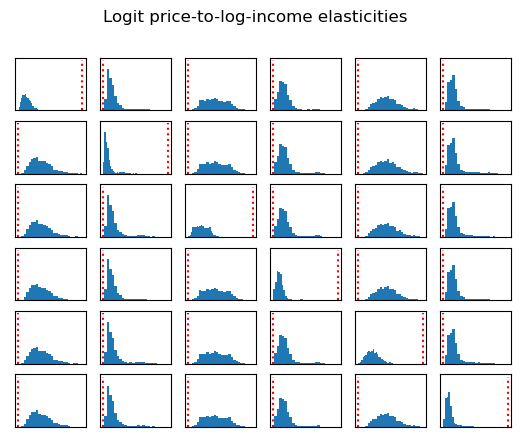

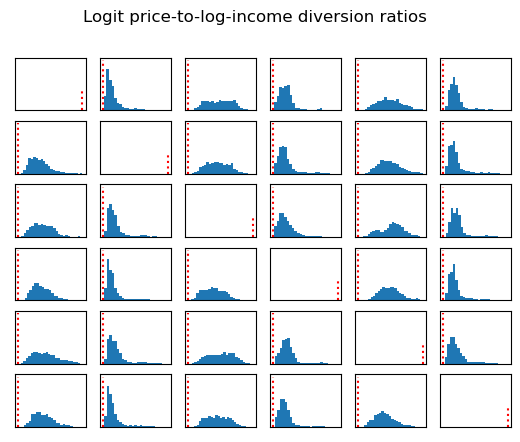

In [1]:
import numpy as np
import pandas as pd 
import os
from numpy import linalg as la
from scipy import optimize
from IPython import display
from matplotlib import pyplot as plt
import itertools as iter

# Files
import Logit_file as logit

Data
====

The data consists of a survey of households regarding their preferences
for car purchase. Each household was given 6 options, but the
characteristics that the respondents were asked about was varied. The
surveys were originally conducted in order to illicit consumer
preferences for alternative-fuel vehicles. The data is *stated
preferences*, in the sense that consumers did not actually buy but just
stated what they would hypothetically choose, which is of course a
drawback. This is very common in marketing when historic data is either
not available or does not provide satisfactory variation. The advantage
of the stated preference data is therefore that the choice set can be
varied greatly (for example, the characteristics includes the
availability of recharging stations, which is important for purchase of
electric cars).

The data has $N=4654$ respondents with $J=6$ cars to choose
from.

Loading the dataset, `car_data.csv`, we get a dataframe with 
$NJ = 27,924$ rows. The column `person_id` runs through $0,1,...,N-1$, and
the column `j` is the index for the car, $\{0,1,...,5\}$. The variable 
`binary_choice` is a dummy, =1 for the car chosen by the respondent. 
A conveneint other variable, `y`, is the index for that car, repeated 
and identical for all $J$ rows for each person. The x-variables describe 
the characteristics of the 6 cars that the respondent was asked to choose 
from. 

We also read in the dataset `car_labels.csv`, which contains the 
variable labels and descriptions for all the variables. 
The list `x_vars` will be used throughout as the list of 
explanatory variables we want to work with. 

In order to get the data into a 3-dimensional array, we access 
the underlying numpy arrays and resize them. For example 

> `x = dat[x_vars].values.resize((N,J,K))`

Note that this will only work because the data is sorted according to 
first `person_id` and then `j`. 

In [2]:
# Load dataset and variable names
input_path = os.getcwd() # Assigns input path as current working directory (cwd)
dat = pd.read_csv(os.path.join(input_path, 'car_data.csv'))
lab = pd.read_csv(os.path.join(input_path, 'car_labels.csv'), index_col = 'variable')

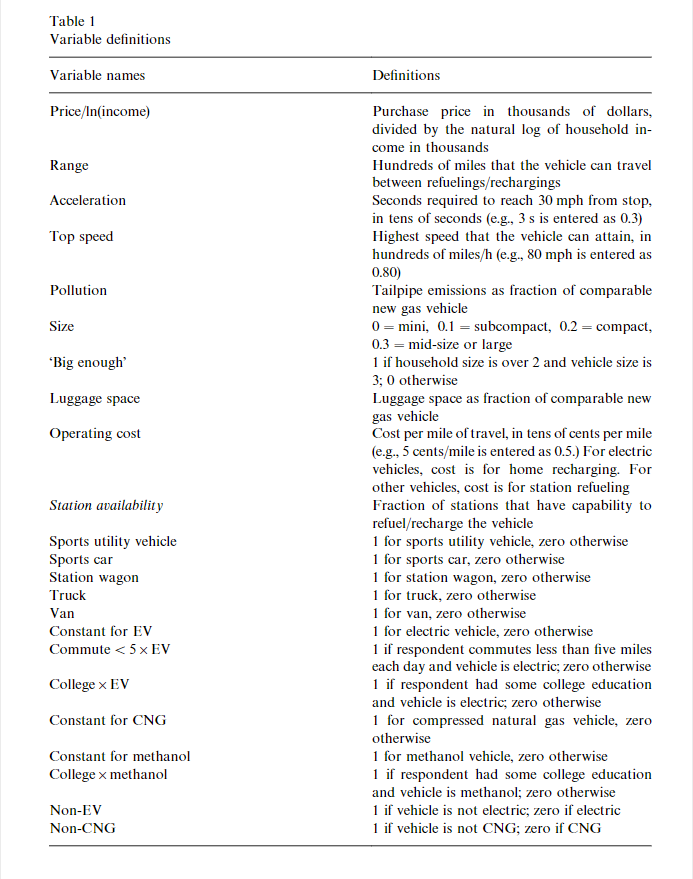

In [3]:
display.Image('brownstone_train_tab_1.PNG')

Table 1 from 'Forecasting new product penetration with flexible substitution patterns (1999), D. Brownstone, K. Train'

## Scaling variables

To be consistent with the interpretation of estimates in 'Brownstone & Train (1999)' we rescale some of the explanatory variables. Furthermore, Logit models are most stable numerically if we ensure that variables are scaled near to $\pm 1$. 

In [4]:
dat['range'] = dat['range'] / 100                  # Hundreds of miles that the vehicle can travel between fuelings
dat['top_speed'] = dat['top_speed'] / 100          # Highest speed that the vehicle can attain, in hundreds of miles per hour
dat['size'] = dat['size'] / 10                     # Scaled categorical variable for numerical purposes
dat['acceleration'] = dat['acceleration'] / 10     # Measured in tens of seconds
dat['operating_cost'] = dat['operating_cost'] / 10 # Measured in tens of cents per mile

Since, respectively, 'EV' and'Non-EV' and also 'CNG' and 'Non-CNG' are equivalent we exclude the latter and keep all the other characteristics as explanatory variables.  

In [5]:
# variables to use as explanatory variables
x_vars = list(lab.iloc[3:-4].index.values) # variable names

In [6]:
# dimensions of data
N = dat.person_id.nunique()
J = dat.j.nunique()
K = len(x_vars)

Finally, we will primarily use numpy data types and numpy functions in this notebook. Hence we store our response variable 'y' and our explanatory variables 'x' as numpy arrays.

In [7]:
# response and explanatory variables as numpy arrays
a = dat['y'].values.reshape((N,J))
a = a[:, 0] # All values are equal along axis=1. Becomes an (N,) array i.e. it is a vector.
y = pd.get_dummies(a).to_numpy() # Convert y to an (N,J) array as the onehot encoding
x = dat[x_vars].values.reshape((N,J,K))

#### Multinomial Logit - for comparison
Estimating a Logit model via maximum likelihood with an initial guess of parameters $\hat \beta^0 = 0$ yields estimated parameters $\hat \beta^{\text{logit}}$ given as...

In [8]:
beta_0 = np.zeros((K,))

# Estimate the model
res_logit = logit.estimate_logit(logit.q_logit, beta_0, a, x)

Optimization terminated successfully.
         Current function value: 1.588275
         Iterations: 86
         Function evaluations: 1914
         Gradient evaluations: 87


In [9]:
logit_beta = res_logit['beta']
pd.DataFrame(logit_beta.reshape(1,len(logit_beta))) # Our estimates

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,-0.185425,0.350097,-0.716186,0.261102,-0.444102,0.934359,0.143349,0.502492,-0.767961,0.413064,...,0.63611,-1.436669,-1.016813,-0.79894,-0.179022,0.198374,0.442935,0.345063,0.313123,0.228548


We then compute the corresponding Logit choice probabilities

In [10]:
logit_q = logit.logit_ccp(logit_beta, x)

We also find the elasticities and diversion ratios implied by the logit model as follows...

In [11]:
epsilon_logit = logit.logit_elasticity(logit_q, logit_beta, 0) # Elasticities wrt. the price-to-log-income characteristic
DR_logit_hat = logit.logit_diversion_ratio(logit_q, logit_beta)

## IPDL Model

### Nests of cars
In our case, we construct nests along the dimensions of 'Fuel Type' and 'Body Type' as suggested by the figure below. Each alternative is assigned to two nests: One representing fuel type (Electric, Combustion/Natural Gas , Methanol) and one representing body type (Car, Truck/Van).

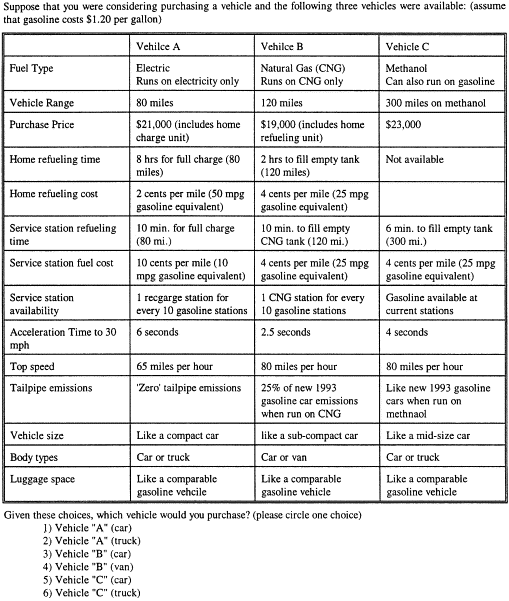

In [12]:
display.Image('brownstone_train_fig_1.gif')

Figure 1 from 'Forecasting new product penetration with flexible substitution patterns (1999), D. Brownstone, K. Train'

# The IPDL model - Nesting structure

The IPDL model is a generalization of the nested logit model where each alternative may belong to more than one nest. Before fully introducing the model, we construct the nesting structure.


## Constructing nests

Let $\Delta=\left\{q\in \mathbb{R}^J_+: \sum_{j=1}^J q_j=1\right\}$ denote the probability simplex. For each group of nests $g=1,\ldots, G$, nest membership is denoted by the matrix $\Psi^g\in \mathbb R^{C_g\times J}$: $\Psi^g_{cj}=1$ if product $j$ belongs to nest $c$ and zero otherwise, and each product can only belong to one nest within each group, meaning that $\sum_{c=1}^{C_g}\Psi^g_{cj}=1$ for all $j$ and all $g$. The matrix-vector product $\Psi^gq$ is then
$$
\Psi^g q=\sum_j \Psi^{g}_{cj}q_j=\left(\begin{array}{c}
\sum_{j:\Psi^g_{1j}=1} q_j \\
\vdots \\
\sum_{j: \Psi^g_{C_gj}=1}q_j
\end{array}\right),
$$
and the vector $\Psi^gq$ is a vector of nest-specific choice probabilities, i.e. the sum of the probabilities within each nest.

## The perturbation function $\Omega$

In the following, a vector $z\in \mathbb R^d$ is always a column vector. We now construct the IPDL perturbation function which has the form (where for a vector $z$, the logarithm is applied elementwise and $z'$ denote the transpose)
$$
\Omega(q|\lambda)= (1-\sum_{g=1}^G \lambda_g) q'\ln q +\sum_{g=1}^{G} \lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right).
$$
Note that since $\Psi^g q$ denotes a probability distribution over the nests, the term $(\Psi^gq)'\ln (\Psi^gq)$ is the (negative) entropy of the probability distribution $\Psi^g q$. Note also that as each nest has at least one member, and $q$ is strictly positive, $\Psi^gq$ is also strictly positive. When the parameters $\lambda_g$ satisfy $\lambda_g>0$ and
$$
\sum_g \lambda_g<1,
$$
the function $\Omega(\cdot|\lambda)$ is a strictly convex function of $q$, and the utility maximization problem has a unique interior (meaning strictly positive choice probabilities) solution. When there is only one group of nests, $G=1$, then $\Omega$ induces the nested logit choice probabilities (note though that the nested logit model is often parameterized in terms of the nesting parameter $\mu=1-\lambda$ instead!). 

It will be convenient to define a choice probability function for a given vector of payoffs $u$ as
$$
P(u|\lambda)=\arg \max_{q\in \Delta}q'u-\Omega(q|\lambda).
$$
Letting $\theta$ denote the full vector of parameters, $\theta=(\beta',\lambda')'$, the individual choice probabilities is a function of the matrix $\mathbf{X}_i$ and the parameters $\theta$, as
$$
p(\mathbf{X}_i,\theta)=\arg\max_{q\in \Delta}q'\mathbf{X}_i \beta-(1-\sum_{g=1}^G\lambda_g)q'\ln q-\sum_{g=1}^G\lambda_g \left(\Psi^g q \right)'\ln \left(\Psi^g q\right)
$$

In [13]:
def Create_incidence_matrix(allocation, x):

    '''
    This function creates the incidence matrices \Psi^g that partition products into nest groupings and nests.
    
    Args.
        allocation: a list of lists with tuples of products j zipped according to their nests in each nest grouping
        x: a matrix of covariates
    
    Output
        psi: a dictionary of the matrices \psi^g as columns
        nests: a numpy array of the amount nests in each nest grouping, i.e. the C_g's
    '''
    
    import numpy as np

    N,J,K = x.shape
    num_groups = len(allocation)

    psi = {}
    C_g = np.empty((num_groups))

    for g in np.arange(num_groups):
        C_g[g] = len(allocation[g])   # Creates a vector of the numbers C^g
        mat = np.zeros((int(C_g[g]), J))

        for k in range(int(C_g[g])):
            mat[k, (allocation[g])[k]] = 1  # Assigns a 1 if product j is in the k'th nest in nest grouping g and zero else
        
        psi[g] = mat

    return psi


In the following, we specify some nests for the IPDL model framework. However, these aren't congruent with Figure 1 as our dataset exhibits variation of product characteristics across individuals. This means that the nesting structure should actually vary across individuals. The nests we have chosen are mostly consistent however.

In [14]:
allocation = [[(0,1), (2,3), (4,5)], [(0, 1, 2), (3, 4, 5)]] # We specify a list of lists containing the different nests as zipped tuples of products j. 

# get nest distribution of products
psi_dict = Create_incidence_matrix(allocation, x)
G = len(allocation) # The number of nest groupings G

We have thereby obtained the incidence matrices $\Psi^1$ and $\Psi^2$ for the Fuel Type and Body Type nest groupings, respectively. For illustration, the incidence matrix $\Psi^1$ for the Fuel Type grouping contains the $C_1=3$ nests 'ev', 'cng', and 'methanol' which partition the $J=6$ cars $\{0,1, \ldots , 5\}$ into the given nests. 
Therefore $\Psi^1$ is a $3$ by $6$ matrix and is given by:

In [15]:
pd.DataFrame(psi_dict[0])

,0,1,2,3,4,5
0,1.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,1.0,1.0


# Max-rescaling for numerical stability

Let $\alpha$ be a scalar, and let $\iota$ be the all-ones vector in $\mathbb R^J$. Note that $q'(u+\alpha\iota)=q'u+(q'\iota)\alpha=q'u+\alpha$, since $q$ sums to one. For this reason, $\alpha$ does not enter into the utility maximization when calculating $P(u+\alpha\iota|\lambda)$, and we have $P(u+\alpha\iota|\lambda)=P(u|\lambda)$.

This allows us to re-scale the utilities just as in the logit model, since $P(u-(\max_{j}u_j)\iota|\lambda)=P(u|\lambda)$. The numerical benefits of this approach carry over to the IPDL model.

## Gradient and Hessian

For purposes of computing the gradient and Hessian of $\Omega$, it is convenient to define
$$
\Gamma=\left(\begin{array}{c}
(1-\sum_g \lambda_g)I_J\\
\lambda_1 \Psi^1\\
\vdots\\
\lambda_G \Psi^G
\end{array}\right)
$$
where $I_J$ is the identity matrix in $\mathbb R^J$. The matrix $\Gamma$ is a block matrix with $J+\sum_g C_g$ rows and $J$ columns. Note that 

$$
\Gamma q=\left(\begin{array}{c}
(1-\sum_g\lambda_g)q \\
\lambda_1\Psi^g q\\
\vdots \\
\lambda_G \Psi^Gq
\end{array}\right)>0
$$
if $q>0$.

Using $\Gamma$, we can show that
$$
\Omega(q|\lambda)=(\Gamma q)'\ln (\Gamma q)+c\\
\nabla_q \Omega(q|\lambda)=\Gamma'\ln (\Gamma q)+\iota\\
\nabla^2_{qq}\Omega(q|\lambda)=\Gamma'\mathrm{diag}(\Gamma q)^{-1}\Gamma,
$$
where $c$ is a scalar that depends on $\lambda$ but not on $q$ and therefore does not affect the utility maximization problem, $\iota=(1,\ldots,1)'\in \mathbb R^J$ is the all-ones vector and $\mathrm{diag}(z)$ is a diagonal matrix with the elements of the vector $z$ on the diagonal.

In [16]:
def CreateGamma(x, Psi, Lambda):
    '''
    This function creates the Gamma matrix. 
    
    Args.
        x: a numpy matrix (N,J,K) of covariates
        Psi: a dictionary of the matrices \psi^g as columns as outputted by 'Create_incidence_matrix'
        Lambda: a numpy array (G,) of grouping parameters \lambda_g
    
    Output
        Gamma: a numpy matrix (J + sum(C_g),J) of nesting parameters times nesting distributions
    '''
    assert x.ndim == 3
    assert Lambda.ndim == 1

    N, J, K = x.shape

    Gamma_dict = {}
    for g in np.arange(len(Psi.keys())+1):
        if g == 0:
            Gamma_dict[g] =  [*((1 - np.sum(Lambda))*np.identity(J))]   # The first J rows are assigned to be diagonal matrix with 1 - sum(\lambda_g) along the diagonal
        else:
            Gamma_dict[g] = [*(Lambda[g-1]*Psi[g-1])] # The next sum(C_g) rows are assigned to be the stacked block matrices \lambda_g*\Psi^g

    Gamma = Gamma_dict[0] # We create the Gamma matrix. This command assigns Gamma to initially be the abovementioned diagonal matrix.
    
    if len(Gamma_dict.keys()) > 1:
        for g in np.arange(1,len(Gamma_dict.keys())):
            Gamma = np.concatenate((Gamma, Gamma_dict[g]), axis=0) # Stacks each of the columns of the dictionary 'Gamma_dict' i.e. the \lambda_g*\Psi^g on top of each other.

    return Gamma

We now create the $\Gamma$ matrix from our nest structure, and set the initial grouping parameters such that $\hat \lambda^0 = \left(\frac{1}{10},\frac{1}{10}\right)'$. Note that $\hat \lambda^0 > 0$ and $\sum_g \hat \lambda_g^0 = \frac{1}{5} < 1$ such that $\Omega(\cdot | \hat \lambda^0)$ is strictly convex.

In [17]:
lambda_0 = 0.1*np.ones((G,)) # set the initial lambda parameters to be one tenth for each nest grouping.
gamma = CreateGamma(x, psi_dict, lambda_0)
pd.DataFrame(gamma)

,0,1,2,3,4,5
0,0.8,0.0,0.0,0.0,0.0,0.0
1,0.0,0.8,0.0,0.0,0.0,0.0
2,0.0,0.0,0.8,0.0,0.0,0.0
3,0.0,0.0,0.0,0.8,0.0,0.0
4,0.0,0.0,0.0,0.0,0.8,0.0
5,0.0,0.0,0.0,0.0,0.0,0.8
6,0.1,0.1,0.0,0.0,0.0,0.0
7,0.0,0.0,0.1,0.1,0.0,0.0
8,0.0,0.0,0.0,0.0,0.1,0.1
9,0.1,0.1,0.1,0.0,0.0,0.0


We remark that $\Gamma$ is  $11$ by $6$ matrix since $J + C_1 + C_2 = 6 + 3 + 2 =11$ in the above example. 

For later use we also set $\hat \theta^0 = \left({ \hat \beta^{\text{logit}}}', {\lambda^{0}}' \right)'$:

In [18]:
logit_theta = np.array([*logit_beta, *lambda_0])

## Model solution

While it is possible to solve for the choice probabilities explicitly by maximizing utility, Fosgerau and Nielsen (2021) suggest a contraction mapping approach which is conceptually simpler. Suppose we are evaluating the likelihood at some guess of the parameters $\theta=(\beta',\lambda')$. Let $u_i=\mathbf{X}_i\beta$, and let $q_i^0$ denote some initial vector of choice probabilities e.g. $q^0_i=\frac{e^{u_i}}{\sum_{j'=1}^Je^{u_{ij'}}}$, we update the choice probabilities according to the formula
$$
v_i^{k} =u_i+\ln q_i^{k-1}-\Gamma'\ln (\Gamma q_i^{k-1})\\
q_i^{k} = \frac{e^{v_i^{k}}}{\sum_{j=1}^J e^{v_{ij}^{k}}},
$$
they show that $\lim_{k\rightarrow \infty}q_i^k=p(\mathbf{X}_i,\theta)$ for any starting value $q^0_i$ in the interior of $\Delta$. For numerical stability, it can be a good idea to also do max-rescaling of $v^k_i$ at every iteration.

Let $p$ denote the solution to the utility maximization problem. Formally, the Kullback-Leibler divergence $D_{KL}(p||q)=p'\ln \frac{p}{q}$ decays linearly with each iteration,
$$
D_{KL}(p||q^{k+1})\leq (\sum_g \lambda_g)D_{KL}(p||q^k),
$$
Noting that $(1-\sum_g \lambda_g)\in [0,1)$ by assumption.

In [19]:
def IPDL_ccp(Beta, x, Gamma, tol = 1.0e-15, maximum_iterations = 1000, MAXRESCALE:bool = True):
    ''' 
    This function finds approximations to the true conditional choice probabilities given parameters.

    Args.
        Beta: a numpy array (K,) of parameters
        x: a numpy matrix (N,J,K) of covariates
        Gamma: a numpy matrix (J + sum(C_g),J) of nesting parameters times nesting distributions as outputted by 'CreateGamma'
        tol: tolerated approximation error
        maximum_iterations: a no. of maximum iterations which if reached will stop the algorithm
        MAXRESCALE: whether or not to max rescale the choice probabilities during iteration

    Output
        q_1: a numpy matrix (N,J) of approximative IPDL choice probabilities
    '''

    u = logit.util(Beta, x)   # Find deterministic utility
    q_0 = logit.logit_ccp(Beta, x)    # Find logit choice probabilities
    q = q_0

    assert u.ndim == 2
    assert q.ndim == 2
    assert Gamma.ndim == 2

    for k in np.arange(maximum_iterations):

        # Calculate gamma*log(gamma*q^(k-1))
        gamma_q = np.einsum('cj,nj->cn', Gamma, q) # First we calculate Gamma*q^(k-1)
        log_gamma_q = np.log(gamma_q) # Then we calculate log(Gamma*q^(k-1))
        gamma_log_prod = np.einsum('cj,cn->nj', Gamma, log_gamma_q) # Finally we multiply Gamma and log(Gamma*q^(k-1)) 

        # Calculate indirect utilities
        v = u + np.log(q) - gamma_log_prod

        if MAXRESCALE:
            v -= v.max(axis=1, keepdims=True) # Max rescaling to improve numerical stability

        # Calculate iterated ccps
        denom = np.exp(v).sum(axis=1, keepdims = True) # (N,1)
        q_1 = np.exp(v) / denom

        # Check convergence in an appropriate distance function
        dist = np.max(np.sum((q_1-q)**2/q_0 , axis=1)) # Uses logit weights. This avoids precision issues when q1~q~0.

        if dist<tol:
            break
        elif k==maximum_iterations:
            break
        else:
            None
        # Iteration step
        q = q_1
    
    return q_1

We then find some IPDL choice probabilities $\hat q_i$ for individuals $i=0,1, \ldots, 4653$ using guess parameters $\hat \theta^0$:


In [20]:
p = IPDL_ccp(logit_beta, x, gamma) # note that our initial guess parameters \lambda^0 enter in the Gamma matrix only
pd.DataFrame(p)

,0,1,2,3,4,5
0,0.120609,0.327414,0.210956,0.103217,0.134994,0.102810
1,0.242507,0.089332,0.303758,0.054051,0.242359,0.067993
2,0.205620,0.057686,0.245616,0.090881,0.343226,0.056972
3,0.138231,0.038780,0.177109,0.060520,0.502029,0.083331
4,0.085097,0.023874,0.176239,0.057877,0.563397,0.093517
...,...,...,...,...,...,...
4649,0.170227,0.047757,0.214351,0.076317,0.421400,0.069948
4650,0.226047,0.063417,0.338955,0.133336,0.204330,0.033916
4651,0.114661,0.150554,0.039621,0.021147,0.147666,0.526352
4652,0.043763,0.155994,0.272676,0.353127,0.109596,0.064844


## Demand derivatives and price Elasticity

While the demand derivatives in the IPDL model are not quite as simple as in the logit model, they are still easy to compute. 
Let $q=P(u|\lambda)$, then
$$
\nabla_u P(u|\lambda)=\left(\nabla^2_{qq}\Omega(q|\lambda)\right)^{-1}-qq'
$$
where the $()^{-1}$ denotes the matrix inverse. The derivatives with respect to any $x_{ij\ell}$ can now easily be computed by the chain rule,
$$
    \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{\partial u_{ik}}{\partial x_{ik\ell}}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell,
$$

Finally, moving to price elasticity is the same as in the logit model, if $x_{ik\ell}$ is the log price of product $k$ for individual $i$, then
$$
    \mathcal{E}_{jk}= \frac{\partial P_j(u_i|\lambda)}{\partial x_{ik\ell}}\frac{1}{P_j(u_i|\lambda)}=\frac{\partial P_j(u_i|\lambda)}{\partial u_{ik}}\frac{1}{P_j(u_i|\lambda)}\beta_\ell=\frac{\partial \ln P_j(u_i|\lambda)}{\partial u_{ik}}\beta_\ell$$
we can also write this compactly as
$$
\nabla_u \ln P(u|\lambda)=\mathrm{diag}(P(u|\lambda))^{-1}\nabla_u P(u|\lambda).
$$

In [21]:
def compute_pertubation_hessian(q, x, Lambda, Psi):
    '''
    This function calucates the hessian of the pertubation function \Omega

    Args.
        q: a (N,J) numpy array of choice probabilities
        Lambda: a (G,) numpy array of nesting parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Hess: a (N,J,J) numpy array of second partial derivatives of the pertubation function \Omega
    '''

    Gamma = CreateGamma(x, Psi, Lambda)

    assert q.ndim == 2
    assert Lambda.ndim == 1

    N,J,K = x.shape
    C = Gamma.shape[0] # is equal to J + sum(C_g)

    gamma_q = np.einsum('cj,nj->nc', Gamma, q)
    Hess = np.einsum('cj,nc,ck->njk', Gamma, 1./gamma_q, Gamma) # Works since einsum merely divides through by c'th element in 1./gamma_q (E.g. diag(\Gamma q)^-1) 

    return Hess

In [22]:
def ccp_gradient(q, x, Lambda, Psi):
    '''
    This function calucates the gradient of the choice proabilities wrt. characteristics

    Args.
        q: a (N,J) numpy array of choice probabilities
        x: a (N,J,K) numpy array of covariates
        Lambda: a (G,) numpy array of nesting parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Grad: a (N,J,K) numpy array of partial derivatives of the choice proabilities wrt. characteristics
    '''

    assert q.ndim == 2

    N,J,K = x.shape

    inv_omega_hess = la.inv(compute_pertubation_hessian(q, x, Lambda, Psi)) # (N,J,J) # For each i=1,...,N , computes the inverse of the J*J Hessian
    qqT = np.einsum('nj,ni->nji', q, q) # (N,J,J) outerproduct
    Grad = inv_omega_hess - qqT

    return Grad

In [23]:
def IPDL_u_grad_Log_ccp(q, x, Theta, Psi):
    '''
    This function calucates the gradient of the log choice proabilities wrt. characteristics

    Args.
        q: a (N,J) numpy array of choice probabilities
        x: a (N,J,J) numpy array of covariates
        Theta: a (K+G,) numpy array of IPDL parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
    
    Returns
        Epsilon: a (N,J,K) numpy array of partial derivatives of the log choice proabilities wrt. characteristics
    '''

    assert q.ndim == 2
    assert x.ndim == 3
    assert Theta.ndim == 1

    N,J,K = x.shape
    
    ccp_grad = ccp_gradient(q, x, Theta[K:], Psi)
    Epsilon = np.einsum('nj,njk->njk', 1./q, ccp_grad) # Is equivalent to (1./q)[:,:,None]*ccp_grad an elementwise product. Einsum merely divides through by the nj'th elemnt of q in k'th row of ccp_grad.

    return Epsilon

In [24]:
def IPDL_elasticity(q, x, Theta, Psi, char_number = 0):
    ''' 
    This function calculates the elasticity of choice probabilities wrt. any characteristic or nest grouping of products

    Args.
        q: a (N,J) numpy array of choice probabilities
        x: a (N,J,K) numpy array of covariates
        Theta: a (K+G,) numpy array of IPDL parameters
        Psi: a dictionary of the \Psi^g matrices as columns as outputted 'Create_incidence_matrix'
        char_number: an integer which is an index of the parameter in theta wrt. which we wish calculate the elasticity 

    Returns
        an (N,J,J) array of choice probability elasticities
    '''
    return IPDL_u_grad_Log_ccp(q, x, Theta, Psi)*Theta[char_number]

Using guess parameters $\hat \theta^0$ we calculate price-to-log-income elasticities for individual $i=0$. 

In [25]:
epsilon0 = IPDL_elasticity(p, x, logit_theta, psi_dict)
pd.DataFrame(epsilon0[0,:,:])

,0,1,2,3,4,5
0,-0.198719,0.089754,0.045973,0.018877,0.025042,0.019072
1,0.033063,-0.142027,0.045973,0.018877,0.025042,0.019072
2,0.026284,0.071353,-0.168213,0.027051,0.024708,0.018818
3,0.022058,0.059881,0.055287,-0.196852,0.033848,0.025779
4,0.022373,0.060737,0.038612,0.025881,-0.183996,0.036393
5,0.022373,0.060737,0.038612,0.025881,0.047786,-0.195388


## Maximum likelihood estimation of IPDL

The log-likelihood contribution is
$$
\ell_i(\theta)=y_i'\ln p(\mathbf{X}_i,\theta),
$$
and an estimation routine must therefore have a function that - given $\mathbf{X}_i$ and $\theta$ - calculates $u_i=\mathbf{X}_i\beta$ and constructs $\Gamma$, and then calls the fixed point routine described above. That routine will return $p(\mathbf{X}_i,\theta)$, and we can then evaluate $\ell_i(\theta)$. Using our above defined functions we now construct precisely such an estimation procedure.

For maximizing the likelihood, we want the derivates at some $\theta=(\beta',\lambda')$. Let $q_i=p(\mathbf{X}_i,\theta)$, then we have
$$
\nabla_\theta \ln p(\mathbf{X}_i,\theta)=\mathrm{diag}(q_i)^{-1}\left(\nabla_{qq}^2\Omega(q_i|\lambda)^{-1}-q_iq_i' \right)\left[\mathbf{X}_i,-\nabla_{q,\lambda}^2 \Omega(q_i|\lambda)\right]
$$
Note that the first two components is the elasticity $\nabla_u \ln P(u|\lambda)$ and the last term is a block matrix of size $J\times dim(\theta)$. The derivative of the log-likelihood function can be obtained from this as
$$
\nabla_\theta \ell_i(\theta)=\nabla_\theta \ln p(\mathbf{X}_i,\theta)' y_i \\
$$

### First we find the loglikelihood contributions

In [26]:
def IPDL_loglikelihood(Theta, a, x, Psi):
    ''' 
    This function computes the loglikehood contribution for each individual i.
    
    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')',
        y: a numpy array (N,J) of observed choices in onehot encoding,
        x: a numpy matrix (N,J,K) of covariates,
        Psi: a dictionary of the matrices \psi^g as columns as outputted by 'Create_incidence_matrix'

    Output
        ll: a numpy array (N,) of IPDL loglikelihood contributions
    '''

    N,J,K = x.shape
    G = len(Psi.keys())

    gamma = CreateGamma(x, Psi, Theta[K:]) # The last G parameters of theta are the nesting parameters \lambda_g
    ccp_hat = IPDL_ccp(Theta[:K], x, gamma) # The first K parameters of theta are those of \beta

    ll = np.log(ccp_hat[np.arange(N), a]) # For each individual find (the log of) the choice probability of the chosen alternative. Is an (N,) array

    return ll

In [27]:
def q_IPDL(Theta, a, x, Psi):
    '''q_IPDL: Criterion function, passed to estimate_IPDL().
    '''
    return -IPDL_loglikelihood(Theta, a, x, Psi)

### Then we compute the gradient of the loglikelihood which we'll use in optimization

In [28]:
def Z_array(psi,q):
    ''' 
    This function calculates the \hat Z matrix i.e. the negative cross differentiated hessian of the pertubation function \Omega

    Args.
        psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'
        q: (N,J) array of choice probabilities

    Returns
        Z: (N,J,G) array of the matrices \hat Z_i
    '''

    N,J=q.shape
    G=len(psi)
    Z=np.empty((N,J,G))
    log_q=np.log(q)
    
    for g in range(G):
        Psi=psi[g]
        Psiq=np.einsum('cj,nj->nc', Psi,q) # Calculates matrix product \Psi^g * q_i.
        
        log_Psiq=np.log(Psiq) 
        Psi_log_Psiq=np.einsum('cj,nc->nj', Psi, log_Psiq) # Calculates matrix product \Psi^g * log(\Psi^g * q_i)
                
        Z[:,:,g] = log_q - Psi_log_Psiq # Assign g'th matrix of Z_{njg} onto the g'th column of Z
        
    return Z

In [29]:
def IPDL_theta_grad_log_ccp(Theta, x, Psi):
    ''' 
    This function calculates the jacobians wrt. parameters \theta for each individual i of log choice probabilities for products j 

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')'
        x: a numpy matrix (N,J,K) of covariates
        Psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'

    Returns
        Theta_grad_log_ccp: a (N,J,K+G) array of derivatives of log choice probabilities for product j wrt. parameters \theta 
    '''
    
    assert Theta.ndim == 1
    assert x.ndim == 3

    N,J,K = x.shape
    G = len(Psi.keys())

    Gamma = CreateGamma(x, Psi, Theta[K:])
    q = IPDL_ccp(Theta[:K], x, Gamma)
    Epsilon = IPDL_u_grad_Log_ccp(q, x, Theta, Psi) # find the gradient wrt. to utility of the log choice probabilities

    neg_cross_hessian_omega = Z_array(Psi, q) # the negative cross differentiated hessian of the pertubation function \Omega
    G = np.concatenate((x, neg_cross_hessian_omega), axis=2) # axis = 2 to join the matrices along axes of dimension K and G, s.t. G is of dimension (N,J,K+G) where dim(Theta) = K+G.

    Theta_grad_log_ccp = np.einsum('nji,nit->njt', Epsilon, G) # is (N,J,K+G). Transposes and computes matrix product.

    return Theta_grad_log_ccp

In [30]:
def IPDL_score(Theta, y, x, Psi):
    ''' 
    This function calculates the jacobians wrt. parameters \theta for each individual i of log choice probabilities for products j 

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')'
        y_onehot: a (N,J) array of onehot/dummy encoded observed choices over products j for each individual i 
        x: a numpy matrix (N,J,K) of covariates
        Psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'

    Returns
        Score: a (N,K+G) array of derivatives of the loglikelihood wrt. parameters \theta 
    '''

    assert x.ndim == 3
    assert y.ndim == 2

    log_ccp_grad = IPDL_theta_grad_log_ccp(Theta, x, Psi)

    Score = np.einsum('njt,nj->nt', log_ccp_grad, y) # Finds the derivatives of the loglikelihood at the observed choices for each individual i.

    return Score

In [31]:
def q_IPDL_score(Theta, y, x, Psi):
    ''' This function creates the jacobian of the criterion function q passed to estimate_IPDL
    '''
    return -IPDL_score(Theta, y, x, Psi)


## Standard errors in Maximum Likelihood estimation

As usual we may consistently estimate the Covariance Matrix  of the IPDL maximum likelihood estimator for some estimate $\hat \theta = (\hat \beta', \hat \lambda')'\in \mathbb{R}^{K+G}$ as:

$$
\hat \Sigma = \left(\sum_{i=1}^N \nabla_\theta \ell_i (\hat \theta) \nabla_\theta \ell_i (\hat \theta)'\right)^{-1}
$$

Thereby we may find the estimated standard error of parameter $d$ as the squareroot of the d'th diagonal entry of $\hat \Sigma$:

$$
\hat \sigma_d = \sqrt{\hat \Sigma_{dd}}
$$

In [32]:
def IPDL_se(Theta, y, x, Psi):
    ''' 
    This function calculates estimated IPDL standard errrors of the MLE

    Args.
        Theta: a numpy array (K+G,) of parameters of (\beta', \lambda')'
        y_onehot: a (N,J) array of onehot/dummy encoded observed choices over products j for each individual i 
        x: a numpy matrix (N,J,K) of covariates
        Psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'
    
    Returns
        SE: a (D,) array of estimated IPDL standard errrors of the MLE
    '''

    N,J,K = x.shape
    d = Theta.shape

    Score = q_IPDL_score(Theta, y, x, Psi)
    Sigma = la.inv( np.einsum('nd,nt->dt', Score, Score) )
    SE = np.sqrt( np.diag(Sigma) )

    return SE

### Finally we estimate our IPDL model using the loglikelihood and its gradient

In [33]:
def estimate_IPDL(f, Theta0, y, a, x, Psi, Analytic_jac:bool = True, options = {'disp': True}, **kwargs):
    ''' 
    Takes a function and returns the minimum, given start values and 
    variables to calculate the residuals.

    Args:
    f: a function to minimize,
    Theta0 : (K+G,) array of initial guess parameters,
    y: a numpy array (N,J) of observed choices in onehot encoding,
    x: array of observed explanatory variables (N,J,K),
    Psi: dictionary of nesting distributions outputted by 'Create_incidence_matrix',
    Analytic_jac: a boolean. Default value is 'True'. If 'True' the analytic jacobian of the IPDL loglikelihood function is used in estimation. Else the numerical jacobian is used.
    options: dictionary with options for the optimizer (e.g. disp=True,
        which tells it to display information at termination.)
    
    Returns:
        res: a dictionary with results from the estimation.
    '''

    # The objective function is the average of q(), 
    # but Q is only a function of one variable, theta, 
    # which is what minimize() will expect
    Q = lambda Theta: np.mean(f(Theta, a, x, Psi))

    if Analytic_jac == True:
        Grad = lambda Theta: np.mean(q_IPDL_score(Theta, y, x, Psi), axis=0) # Finds the Jacobian of Q. Takes mean of criterion q derivatives along axis=0, i.e. the mean across individuals.
    else:
        Grad = None

    # call optimizer
    result = optimize.minimize(Q, Theta0.tolist(), options=options, jac=Grad, **kwargs) # optimize.minimize takes a list of parameters Theta0 (not a numpy array) as initial guess.

    # collect output in a dict 
    res = {
        'theta': result.x,
        'se': IPDL_se(result.x, y, x, Psi),
        'success':  result.success, # bool, whether convergence was succesful 
        'nit':      result.nit, # no. algorithm iterations 
        'nfev':     result.nfev, # no. function evaluations 
        'fun':      result.fun # function value at termination 
    }

    return res

Estimating our IPDL model then yields estimates $\hat \theta^{\text{IPDL}}$ given by...

In [34]:
res_an = estimate_IPDL(q_IPDL, logit_theta, y, a, x, psi_dict)

Optimization terminated successfully.
         Current function value: 1.575854
         Iterations: 84
         Function evaluations: 86
         Gradient evaluations: 86


In [35]:
IPDL_theta = res_an['theta']
pd.DataFrame(res_an)[['theta', 'se']].transpose()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,22
theta,-0.110086,0.232633,-0.457754,0.189331,-0.278106,0.631611,0.078315,0.304103,-0.490831,0.258483,...,-0.235755,-0.153667,-0.213902,0.126200,0.256145,0.129072,0.158436,0.116742,0.452531,0.351414
se,0.021690,0.028853,0.087550,0.057961,0.076642,0.227739,0.052262,0.131070,0.068008,0.069757,...,0.040639,0.030400,0.118885,0.057377,0.078051,0.066300,0.072630,0.062586,0.086379,0.068671


The corresponding implied choice probabilities $\hat q_i$ for $i=0,1,\ldots,4653$ of the MLE estimates $\hat \theta^{\text{IPDL}}$ can thus be found using our earlier algorithm

In [36]:
gamma_hat = CreateGamma(x, psi_dict, IPDL_theta[K:])
ccp_hat_IPDL = IPDL_ccp(IPDL_theta[:K], x, gamma_hat)

pd.DataFrame(ccp_hat_IPDL)

,0,1,2,3,4,5
0,0.093428,0.204586,0.245410,0.155348,0.181692,0.119536
1,0.191896,0.087633,0.273682,0.084924,0.278262,0.083602
2,0.199207,0.059851,0.226299,0.093041,0.347978,0.073623
3,0.152024,0.045675,0.200162,0.043492,0.461091,0.097555
4,0.097747,0.029368,0.227782,0.035640,0.503034,0.106429
...,...,...,...,...,...,...
4649,0.166694,0.050082,0.229465,0.071166,0.398319,0.084274
4650,0.198616,0.059673,0.279873,0.168121,0.242425,0.051291
4651,0.128157,0.194795,0.079501,0.027567,0.131684,0.438297
4652,0.035110,0.116860,0.298629,0.318160,0.135688,0.095552


Using $\hat \theta^{\text{IPDL}}$ and $\hat q_i$ for $i=0,1,\ldots,4653$ we can find the implied choice probability elasticities $ \mathcal{E} $ with respect to price-to-log-income. For individual $i=0$ we find:

In [37]:
epsilon_IPDL = IPDL_elasticity(ccp_hat_IPDL, x, IPDL_theta, psi_dict, 0)
pd.DataFrame(epsilon_IPDL[0,:,:])

,0,1,2,3,4,5
0,-0.419253,0.311495,0.069418,0.000916,0.022573,0.014851
1,0.142250,-0.250008,0.069418,0.000916,0.022573,0.014851
2,0.026428,0.057871,-0.197769,0.102905,0.006373,0.004193
3,0.000551,0.001207,0.162563,-0.274187,0.066269,0.043598
4,0.011607,0.025417,0.008608,0.056660,-0.284520,0.182228
5,0.011607,0.025417,0.008608,0.056660,0.276983,-0.379275


Again we find for individual $i=0$ that all the diagonal entries are negative, whence all products $j\in\{0,1,\ldots,5\}$ are normal. Furthermore, note that the general IIA property no longer holds. Instead, products $j_1,j_2$ which are of the same 'type' (i.e. for all nest groupings $g=1,2$ products $j_1$ and $j_2$ belong to the same nest) have the same cross-elasticities with respect to any product $\ell \neq j_1, j_2$. For example, products $j_1=0$ and $j_2=1$ are both in the 'EV'- and 'Car'- nests, such that they of the same type, and we see that wrt. product $\ell = 2$ the price-to-log-income elasticities are equal: $\mathcal{E}_{02} = 0.069 = \mathcal{E}_{12}$.

### Visualization of elasticities

First we plot the elasticities of the Logit model in a matrix of histograms. The red dotted line indicates the elasticity $\mathcal{E}^* = 0$.

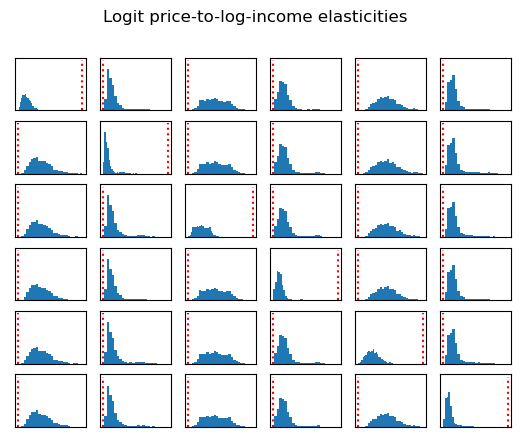

In [38]:
own_elasticities_logit = {j : (epsilon_logit.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_elasticities_logit[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Logit price-to-log-income elasticities')

plt.show()

Here the $j$'th row represents the elasticity of the choice probability of product $j$ wrt. the price-to-log-income of every other product $k = 1,\ldots,6$. Similarly we plot histograms of the elasticities for the IPDL model.

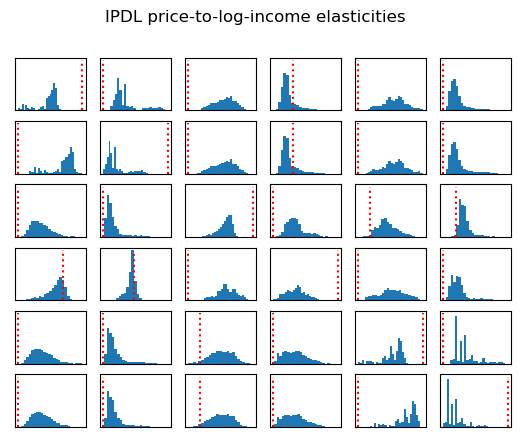

In [39]:
own_elasticities_IPDL = {j : (epsilon_IPDL.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_elasticities_IPDL[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('IPDL price-to-log-income elasticities')
plt.show()

### Diversion ratios for the IPDL model

The diversion ratio to product j from product k is the fraction of consumers leaving product k and switching to product j following a one percent increase in the price of product k. Hence we have:

$$
\mathcal{D}_{jk}^i = -100 \cdot \frac{\partial P_j(u_i|\lambda) / \partial x_{ik\ell}}{\partial P_k(u_i|\lambda) / \partial x_{ik\ell}} = -100 \cdot \frac{\partial P_j(u_i|\lambda) / \partial u_{ik}}{\partial P_k(u_i|\lambda) / \partial u_{ik}}
$$

Where $\mathcal{D}^i = \left( \mathcal{D}_{jk}^i \right)_{j,k \in \{0,1,\ldots ,5\}}$ is the matrix of diversion ratios for individual i. This can be written more compactly as:

$$
\mathcal{D}^i = -100 \cdot  \nabla_u P(u|\lambda)(\nabla_u P(u|\lambda) \circ I_J)^{-1}
$$

In [40]:
def IPDL_diversion_ratio(q, x, Theta, Psi):
    '''
    This function calculates diversion ratios from the IPDL model

    Args.
        q: an (N,J) array of choice probabilities
        x: an (N,J,K) array of covariates
        Theta: an (K+G,) array of parameters
        Psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'

    Returns
        Diversion_ratio: an (N,J,J) array of diversion ratios from product j to product k for each individual i
    '''

    N,J,K = x.shape

    Grad = ccp_gradient(q, x, Theta[K:], Psi) 
    diagonal_of_Grad = np.einsum('njk,jk->njk', Grad, np.eye(J,J)) # Finds the derivatives of choice probabilities for product j wrt. the own price of product j. Computes a hadamard product. Is diagonal.
    diag_of_Grad_iota = np.diagonal(diagonal_of_Grad, axis1=1, axis2=2) # Takes the diagonals into vectors. (Is equal to \nabla_u P(u|\lambda) \circ I_J) * \iota a vector of the diagonal elements.
    Diversion_Ratio = -100 * np.einsum('njk,nj->njk', Grad, 1./diag_of_Grad_iota) # Computes an elementwise product
    
    return Diversion_Ratio 

Calculating the implied diversion ratios $\mathcal{ D}^i$ from our estimates $\hat \theta^{\text{IPDL}}$, we find for individual $i=0$:

In [41]:
DR_IPDL_hat = IPDL_diversion_ratio(ccp_hat_IPDL, x, IPDL_theta, psi_dict) # Note that we use our estimated choice probabilities here as well.
pd.DataFrame(DR_IPDL_hat[0,:,:])

,0,1,2,3,4,5
0,-100.000000,74.297720,16.557619,0.218524,5.383989,3.542149
1,56.898348,-100.000000,27.766436,0.366456,9.028725,5.940036
2,13.362908,29.261668,-100.000000,52.032784,3.222526,2.120113
3,0.200955,0.440046,59.289013,-100.000000,24.169060,15.900926
4,4.079514,8.933188,3.025503,19.914241,-100.000000,64.047554
5,3.060324,6.701399,2.269638,14.939042,73.029597,-100.000000


### Visualisation of diversion ratios
We first plot our earlier Logit diversion ratios in histograms of individuals' diversion ratio to product j from product k. The red dotted line denotes the diversion ratio $\mathcal{D}^* = 0$.

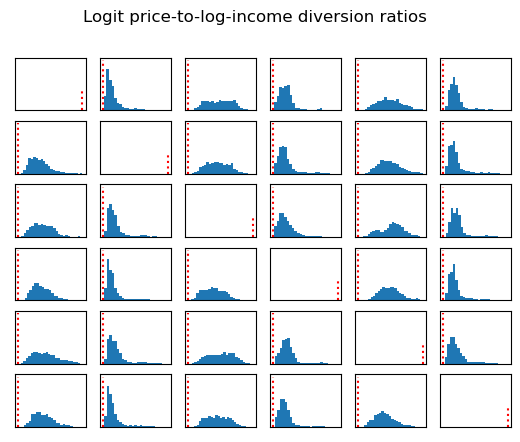

In [42]:
own_DR_logit = {j : (DR_logit_hat.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_DR_logit[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('Logit price-to-log-income diversion ratios')
plt.show()

The $j$'th row represents the diversion ratios of product $j$ wrt. to each other product $k=1,\ldots,6$. We also plot our diversion ratios for IPDL.

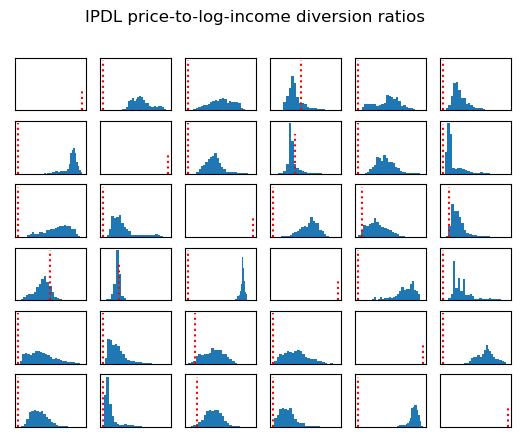

In [43]:
own_DR_IPDL = {j : (DR_IPDL_hat.reshape((N, J**2))[:,j]).flatten() for j in np.arange(J**2)} # Finds j'th entry in each of the elasticity matrices of individuals i.  

j_pairs = iter.product(np.arange(J), np.arange(J))
num_bins = 25

fig, axes = plt.subplots(J, J)

for p, j in zip(j_pairs, np.arange(J**2)):
    axes[p].hist(own_DR_IPDL[j], num_bins)
    axes[p].vlines(0, 0, 1500, 'red', 'dotted')
    axes[p].get_xaxis().set_visible(False)
    axes[p].get_yaxis().set_visible(False)

fig.suptitle('IPDL price-to-log-income diversion ratios')
plt.show()

## Alternative estimation algorithm

The FKN estimator begins with a nonparametric estimate of the CCP function, yielding choice probabilities $\hat q^0_i$ for $i=1,\ldots,N$. We wish to find parameters such that the PUM first-order condition is approximately satisfied at $\hat q^0_i$, i.e. $\hat \theta^0$ such that 
$$
\hat q_i^0\approx P(X_i,\hat \theta^0),
$$
approximately over the sample. We introduce a residual,
$$
\hat \varepsilon^0_i(\theta)=\hat D^0_i(u(X_i,\beta)- \nabla_q \Omega(\hat q_i^0|\lambda)),
$$
where $\hat D^0_i=\textrm{diag}(\hat q^0_i)-\hat q^0_i (\hat q^0_i)'$. We have already seen that we can write
$$
u(X_i,\beta)-\nabla_q \Omega(\hat q_i^0|\lambda)=\hat G^0_i \theta-\ln \hat q^0_i
$$
where $\hat G^0_i=[X_i,\hat Z_i^0]$. Letting $\hat A^0_i=\hat D^0_i \hat G^0_i$ and $\hat r_i^0=\hat D^0_i \ln \hat q^0_i$, we therefore have
$$
\hat \varepsilon^0_i(\theta)=\hat A^0_i\theta-\hat r^0_i.
$$
We minimize the weigthed mean of these residuals over $\theta$, with weights $\hat W^0_i=\textrm{diag}(\hat q^0_i)^{-1}$,

$$
\hat \theta^0 =\arg \min_{\theta} \frac{1}{N}\sum_i \hat \varepsilon_i(\theta)'\hat W_i^0 \hat \varepsilon_i(\theta)
$$
which has the closed-form solution
$$
\hat \theta^0 =\left(\frac{1}{N}\sum_i  (\hat A^0_i)'\hat W^0_i \hat A^0_i \right)^{-1}\left(\frac{1}{N}\sum_i  (\hat A^0_i)'\hat W^0_i \hat r_i^0 \right)
$$


In [44]:
def G_array(q, x, Psi):
    ''' 
    This function calculates the G block matrix

    Args.
        q: an (N,J) array of choice probabilities
        x: an (N,J,K) array of covariates
        Psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'

    Returns
        G: a (N,J,K+G) numpy array a G matrix for each individual i
    '''
    Z = Z_array(Psi, q) # Find the Z matrix
    G = np.concatenate( (x,Z), axis=2) # Join block matrices along 3rd dimensions

    return G

In [45]:
def WeightedLeastSquares(A,W,r):
    ''' 
    This function calculates the weighted least squares estimator \hat \theta^k and its relevant estimated standard error.

    Args.
        G: (N,J,K+G) array of the \hat G_i matrices
        W: (N,J,J) array of weights \hat W_i
        r: (N,J) array of the \hat r_i vectors

    Returns
        theta_hat: (K+G,) array of estimated parameters
        se_hat: (K+G,) array of estimated standard error of parameters 
    '''

    N = A.shape[0]
    
    AWA = np.einsum('nja,njk,nkb->ab',A,W,A,optimize=True)/N # Calculates the matrix product GWG
    AWr = np.einsum('nja,njk,nk->a',A,W,r,optimize=True)/N # Calculates the matrix product GWr
    
    theta_hat = la.solve(AWA,AWr) # Solves the system of equation GWG*\theta = GWr for \theta, which are the estimated parameters
    #theta_hat=la.lstsq(GWG,GWr,rcond=None)[0] # better numerically in some case
    
    cov_hat = la.inv(AWA)/N # Calculates the (K+G,K+G) estimated covariance matrix of parameters \theta
    se_hat = np.sqrt(np.diag(cov_hat)) # Calculates the estimated standard errors of parameters \theta
    
    return theta_hat,se_hat
    

In [46]:
def FKN_initial(q, x, Psi):
    '''
    This function calculates the initial FKN estimate on which to iterate

    Args.
        q: an (N,J) array of choice probabilities
        x: an (N,J,K) array of covariates
        Psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'

    Returns
        theta_hat: a (K+G,) numpy array of IPDL parameters
        se_hat: a (K+G,) numpy array of estimated IPDL standard errors of parameters
    '''

    N,J,K = x.shape
    G = G_array(q, x, Psi)
    
    diag_q = np.eye(J)[None,:,:] * q[:,:,None] # Computes the diag(q) matrix. Is equivalent to np.einsum('jk,nj->njk', np.eye(J), q).
    qqT = q[:,:,None] * q[:,None,:] # Computes an outer product of q with itself. Is equivalent to np.einsum('nj,nk->njk', q, q).
    D = diag_q - qqT 
    A = np.einsum('njk,nkd->njd', D, G)  # Is of dimension (N,J,K+C). Is a matrix product.
    W = np.eye(J)[None,:,:] / q[:,:,None] # Computes inverse diag(q) matrix. Is equivalent to np.einsum('jk,nj->njk', np.eye(J), 1./q).
    r = np.einsum('njk,nk->nj', D, np.log(q)) # Calculates matrix product

    theta_hat,se_hat = WeightedLeastSquares(A,W,r) # find estimated WLS parameters using closed form solution
    
    return theta_hat,se_hat

### Nonparametric estimation of the choice probabilities

The choice probabilities are a function of the entire vector of explanatory variables $x_i=\textrm{vec}(X_i)$. We stack these into a matrix $\mathbf{X}$ of size $N\times JK$.

This is a high-dimensional estimation problem. In order to reduce the dimensionality, we do a truncated singular value decomposition, i.e. fit a matrix $\mathbf{\tilde X}$ of size $N\times D$ where $D\leq JK$ and $\mathbf{\tilde X}\approx \mathbf X$.

We then estimate a bagged logistic regression with response variable $\mathbf a=(a_i)_{i=1}^N$ and input $\mathbf{\tilde X}$. 

For further details, see the scikit learn documentation or Elements of Statistical Learning (Hastie et al 2009).


We now find initial estimates of choice probabilities $\hat q_i^0$ by implementation of the above . 

In [47]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
# from sklearn.ensemble import BaggingClassifier

# Create two-dimensional array X for input into ML function

X = np.empty((N,J*K))

for i in range(N):
    X[i,:] = x[i,:,:].flatten()

# Do dimensionality reduction

pca = PCA(n_components='mle')
X_pca = pca.fit_transform(X)

logistic = LogisticRegression(random_state=0, multi_class='multinomial', max_iter=10000)


fitted = logistic.fit(X_pca, a) # Fit logit probabilities 
p_hat = fitted.predict_proba(X_pca) # Find some initial guess of choice probabilities

Based on our above estimate of choice probabilities $\hat q_i^0$ we find an initial estimate $\hat \theta_{FKN}^0$ of parameters.

In [48]:
theta_hat,se_hat = FKN_initial(p_hat, x, psi_dict)

In [49]:
print(np.round(theta_hat,decimals=2)) # Estimated paramters. 
print(theta_hat[K:].sum()) # Convexity check for whether sum of the lambda is less than 1

[-0.13  0.22 -0.43  0.19 -0.33  0.65  0.11  0.37 -0.55  0.3   0.01 -0.01
 -0.09 -0.   -0.09 -0.06  0.11  0.34  0.32  0.25  0.17  0.57  0.44]
1.0103413660586797


## Regularization for parameter bounds

As we see above, the least squares estimator is not guaranteed to respect the parameter bounds $\sum_g \hat \lambda_g<1$. However, we know that the logit probabilities $\hat q^{logit}_i$ returns the estimates $\hat \theta^{logit}=(\hat \beta^{logit},0,0)'$. We can construct a sequence of estimators using the mixture probabilities
$$
\hat q^{(t)}_i =(1-\alpha_t) \hat q^{logit}_i+\alpha_t \hat q_i
$$
and we know that $\hat q^{(t)}_i$ respects the parameter bounds for $\alpha_t$ sufficiently close to zero by continuity. We can then compare the likelihood values of each $\hat \theta^{(t)}$ and pick the best one. This ensures that the likelihood value of the initial estimator is at least as good as the logit solution. 

Note that the benefit of doing this is that we only ever need to do a one-dimensional grid search on the interval $[0,1]$ which is very simple. 
$$
\hat \theta^*=\arg \max_{t} \mathcal L_N(\hat \theta^{(t)})
$$


In [50]:
def LogL(Theta, y = a, x = x, Psi = psi_dict):
    ''' 
    This function calculates the mean loglikelihood contribution.

    Args.
        Theta: (K+G,) array of parameters
        y: (N,) array of observed choices
        x: (N,J,K) array of covariates
        Psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'
    '''
    return np.mean(IPDL_loglikelihood(Theta, y, x, Psi))

0.25


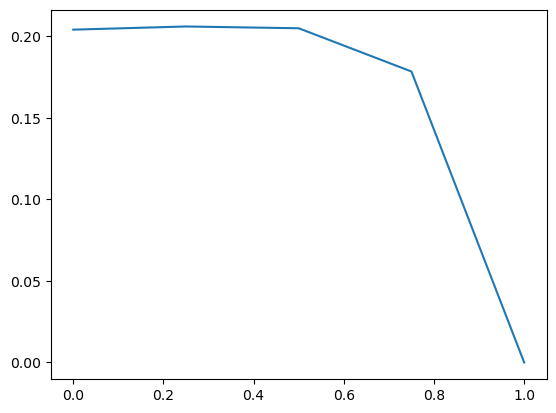

In [51]:
num_alpha = 5
alpha_line = np.linspace(0, 1, num_alpha)
logl_alpha = np.empty((num_alpha))

theta_hat_alpha = np.empty((K+G, num_alpha))
for k in range(num_alpha): # for alpha in alpha_line:

    alpha = alpha_line[k]
    
    if alpha == 0:
        theta_hat_alpha[:,k] = logit_theta # If alpha = 0 get logit paramters
    
    else: # If alpha > 0 get parameters stemming from mixture probabilities
        q_alpha = (1-alpha) * logit_q + alpha * p_hat  # Compute mixture probabilities
        theta_hat_alpha[:,k] = FKN_initial(q_alpha, x, psi_dict)[0] # Get corresponding 'mixture' parameters

    if theta_hat_alpha[K:,k].sum() > 0.999:
        logl_alpha[k] = np.NINF # Set loglikelihood to minus infinity if constraint on lambda parameters is not satisfied
    else:
        logl_alpha[k] = LogL(theta_hat_alpha[:,k], a, x, psi_dict) # Evaluate loglikelihood at parameters
    
# Pick the best one:

best_index = np.argmax(logl_alpha) # Find the best t
best_alpha = alpha_line[best_index] # Find the best alpha 
theta_hat_star = theta_hat_alpha[:,best_index] # Find the best parameters
print(best_alpha)
# easier to see the pattern for the likelihood instead of the log
plt.plot(alpha_line, np.exp(logl_alpha)) 

In [52]:
# we see that the estimates are meaningfully better than the logit starting values

print(np.round(IPDL_theta - logit_theta, decimals=2))
print(np.round(IPDL_theta - theta_hat_star, decimals=2))

# In fact, there is only one parameter where the logit is closer to the MLE.
print(np.abs(IPDL_theta - logit_theta) > np.abs(IPDL_theta - theta_hat_star))

[ 0.08 -0.12  0.26 -0.07  0.17 -0.3  -0.07 -0.2   0.28 -0.15 -0.65 -0.5
  1.13  0.78  0.65 -0.03 -0.07 -0.19 -0.22 -0.15 -0.11  0.35  0.25]
[ 0.05 -0.06  0.14 -0.04  0.11 -0.19 -0.05 -0.13  0.17 -0.09 -0.27 -0.2
  0.48  0.31  0.29 -0.06 -0.04 -0.13 -0.18 -0.1  -0.08  0.15  0.15]
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True  True  True]


## Iterated FKN estimator

The iterated estimator is as the initial one, except there is an additional term on $\hat \varepsilon$. First, we update the choice probabilities,
$$
\hat q^k_i=p(\mathbf X_i,\hat \theta^{k-1})\\
$$
Then we assign
$$
\hat D^k_i=\nabla^2_{qq}\Omega(\hat q_i^k|\hat \lambda^{k-1})^{-1}-(\hat q^k_i \hat q^k_i)'
$$
and then construct the residual
$$
\hat \varepsilon^k_i(\theta)=\hat D^k_i\left( u(x_i,\beta)-\nabla_q \Omega(\hat q_i^k|\lambda)\right) -y_i+\hat q_i^k,
$$
Which can once again be simplified as
$$
\hat \varepsilon^k_i(\theta)= \hat A_i^k \theta-\hat r^k_i,
$$
where
$$
\hat A^k_i=\hat D_i^k\hat G^k_i, \hat r_i^k =\hat D^k_i\ln \hat q_i^k-y_i
$$
and where $\hat G^k_i$ is constructed as in the initial estimator. Using the weighted least squares estimator with weights $\hat W_i^k=\textrm{diag}(\hat q^k_i)^{-1}$, we get the estimator
$$
\hat \theta^k = \arg \min_{\theta}\frac{1}{n}\sum_i \hat \varepsilon^k_i(\theta)'\hat W_i^k \hat \varepsilon^k_i(\theta).
$$
We can once again solve it in closed form as
$$
\hat \theta^k =\left( \frac{1}{n}\sum_i \hat (A^k_i)'\hat W_i^k \hat A^k_i)\right)^{-1}\left( \frac{1}{n}\sum_i (\hat A_i^k)'\hat W_i^k \hat r_i^k\right)
$$
Now we implement this procedure and iterate starting from our initial guess $\hat \theta^{*}$


In [53]:
def FKN_Iterated(theta, y, x, psi):
    ''' 
    This function calculates the step iterated estimate of parameters \hat \theta^k and its estimated standard error.
    Args.
        y: (N,J) array of observed choices as onehot encoding
        x: (N,J,K) array of covariates
        psi: dictionary of nest groupings as outputted by 'Create_incidence_matrix'
        theta: (K+G,) array of parameters from the previous iteration step. Note that an initial guess of parameters \hat \theta^0 must be specified.

    Returns
        theta_hat: (K+G,) array of estimated parameters for this iteration step
        se_hat: (K+G,) array of estimated standard error of parameters for this iteration step
    '''

    Gamma = CreateGamma(x, psi, theta[K:])
    q = IPDL_ccp(theta[:K], x, Gamma)
    
    Gamma_q = np.einsum('cj,ij->ic', Gamma, q) # is equal to Gamma*q_i stacked on each other over the individuals i
    
    H = np.einsum('cj,ic,ck->ijk', Gamma, 1./Gamma_q, Gamma) 
    H_inv = np.linalg.inv(H) #
    qqT = q[:,None,:] * q[:,:,None]
    D = H_inv - qqT
    
    G = G_array(q, x, psi_dict)  # Create the block matrix [X_i, \hat Z_i]. Joins along the K and G dimensions respectively of X and Z
    
    A = np.einsum('njk,nkl->njl', D, G) # Computes A_i = D_i * [X_i,Z_i] and stacks them along the individuals dimension.
    W = 1./q[:,:,None] * np.eye(q.shape[1])[None,:,:] # Returns W[i,:,:]= diag(q)^{-1}-\iota \iota'. Is equivalent to W=np.einsum('ij,jl->ijl', 1./q, np.eye(q.shape[1]))-1 . Computes the elementwise product of (N,J) along third dimension J and (J,J) along first dimension N. Uses broadcasting of the all 1's (N,J,J) matrix. 
    Dlog_q = np.einsum('njl,nl->nj', D, np.log(q)) # Computes diag(q_i)*log(q_i) and stacks these vectors along the individuals dimension N 
    
    r = Dlog_q + y # Computes the (N,J) array of the r_i
    
    theta_hat,se_hat = WeightedLeastSquares(A,W,r)
    
    return theta_hat,se_hat

In [54]:
# Find FKN parameters

FKN_iters = 100
THETA = np.empty((K+G,FKN_iters))
SE = np.empty((K+G,FKN_iters))
LOGL = np.empty(FKN_iters)
tol = 1.0e-4
theta_old = theta_hat_star

for k in range(FKN_iters):
    
    theta_new,se_new = FKN_Iterated(theta_old, y, x, psi_dict)
    
    THETA[:,k],SE[:,k] = theta_new,se_new
    LOGL[k] = LogL(theta_new)
    
    if la.norm(theta_new-theta_old)<tol:
        break 
        
    theta_old = theta_new

In [60]:
THETA[:,10] - IPDL_theta

array([-1.57289099e-05, -3.23308026e-05,  4.24071052e-05, -3.24018407e-06,
        5.79145261e-06,  1.46234903e-05,  1.11670396e-05,  5.19835489e-05,
        1.30619078e-05, -2.59584854e-05, -3.29565895e-05, -3.01679682e-05,
        1.05029983e-04,  7.37466249e-05,  3.72551437e-05,  1.72181640e-04,
        1.63372271e-05,  2.29756290e-05,  1.36878545e-04,  3.04151571e-05,
        4.32966961e-05, -5.86153667e-05,  1.38084850e-04])

In [59]:
LOGL

array([-1.57683542, -1.57605952, -1.57591678, -1.57587265, -1.5758601 ,
       -1.57585605, -1.5758548 , -1.57585438, -1.57585424, -1.57585419,
       -1.57585418, -1.57585417, -1.57585417, -1.57585417, -1.57585417,
       -1.57585417,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

We see that iterating all the way to convergence took some time, but the parameters are almost identical to IPDL_theta even after a few iterations.